In [1]:
import torch
import numpy as np

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# **NEURAL NETWORK**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

In [5]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, layer_size):
        super(PINN, self).__init__()
        self.lambda_1 = nn.Parameter(torch.Tensor([0]), requires_grad=True)
        self.lambda_2 = nn.Parameter(torch.Tensor([0]), requires_grad=True)

        self.fc1 = nn.Linear(input_dim, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, output_dim)

        

    def forward(self, input_0, input_1, dt, IRK_alpha, IRK_beta):
        u_0 = self.forward_iteration(input_0, dt, IRK_alpha.T, True)
        u_1 = self.forward_iteration(input_1, dt, (IRK_beta-IRK_alpha).T, False)
        return u_0, u_1



    def forward_iteration(self, x, dt, IRK_weights, flag_u0):
        x.requires_grad_(True)

        s = nn.Tanh()(self.fc1(x.float()))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        u = self.fc4(s)
        u_x = self.fwd_gradients(u, x)
        u_xx = self.fwd_gradients(u_x, x)
        f = - self.lambda_1*u*u_x + self.lambda_2*u_xx
        
        if flag_u0:
            u_ = u - dt * torch.mm(f.double(), IRK_weights.double())
        else: #flag_u1
            u_ = u + dt * torch.mm(f.double(), IRK_weights.double())

        return u_


    def fwd_gradients(self, U, x):
        z = torch.ones(U.shape).to(device).requires_grad_(True)
        g = autograd.grad(U, x, grad_outputs=z, create_graph=True)[0]
        return autograd.grad(g, z, grad_outputs=torch.ones(g.shape).to(device), create_graph=True)[0]

# **OPTIMIZATION**

In [6]:
from torch.optim import LBFGS
from time import time
from tqdm.notebook import tqdm as tqdm

In [7]:
class Train():
    def __init__(self, network, input_0, target_0, input_1, target_1, dt, q):
        self.net = network

        self.lbfgs_optim = LBFGS(self.net.parameters(), lr=1, max_iter=50000, line_search_fn='strong_wolfe')

        tmp = np.float32(np.loadtxt('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        weights = torch.from_numpy(np.reshape(tmp[0:q**2+q], (q+1, q)))
        self.IRK_alpha = weights[0:-1, :].to(device)
        self.IRK_beta = weights[-1:, :].to(device)
        self.IRK_times = torch.from_numpy(tmp[q**2+q:]).to(device)

        self.train_input_0, self.train_target_0,  = input_0.to(device), target_0.to(device)

        self.train_input_1, self.train_target_1 = input_1.to(device), target_1.to(device)
    
        self.dt = torch.tensor(dt).to(device)
        



    def train(self): 
        start_time = time()

        self.train_iteration(self.train_input_0, self.train_target_0, self.train_input_1, self.train_target_1)

        end_time = time()
        print('Time:', end_time - start_time)     



    def train_iteration(self, input_0, target_0, input_1, target_1):
        
        def closure(): 
            if torch.is_grad_enabled():
                self.lbfgs_optim.zero_grad()
            predict_0, predict_1 = self.net(input_0, input_1, self.dt, self.IRK_alpha, self.IRK_beta)
            loss = self.loss_function(predict_0, target_0, predict_1, target_1)
            if loss.requires_grad:
                loss.backward()
            return loss
        self.lbfgs_optim.step(closure)



    def loss_function(self, predict_0, target_0, predict_1, target_1): #correct
        loss = torch.sum(torch.square(predict_0 - target_0)) + torch.sum(torch.square(predict_1 - target_1))
        return loss


# **MAIN**


## DATA PREPERATION

In [8]:
import scipy.io

COLLECTING THE DATA

In [9]:
data = scipy.io.loadmat('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/appendix/Data/burgers_shock.mat')

t_data = data['t']  # SHAPE (100, 1)
x_data = data['x']  # SHAPE (256,1)
u_data = np.real(data['usol']).T  # SHAPE (100, 256)

lb = np.array([-1.0])
ub = np.array([1.0])
N0 = 199
N1 = 201 #number of x data points

In [10]:
idx_x0 = np.random.choice(u_data.shape[1], N0, replace=False) 
idx_t0 = 10

x_0 = x_data[idx_x0, :]
x_0 = torch.from_numpy(x_0)#.view(-1, 1)

u_0 = u_data[idx_t0, idx_x0].T
u_0 = torch.from_numpy(u_0).view(-1, 1)
print('0 INPUT SHAPE:', x_0.shape)
print('0 TARGET SHAPE:', u_0.shape)


0 INPUT SHAPE: torch.Size([199, 1])
0 TARGET SHAPE: torch.Size([199, 1])


In [11]:
idx_x1 = np.random.choice(u_data.shape[1], N1, replace=False) 
idx_t1 = 90

x_1 = x_data[idx_x1, :]
x_1 = torch.from_numpy(x_1)

u_1 = u_data[idx_t1, idx_x1].T
u_1 = torch.from_numpy(u_1).view(-1, 1)
print('1 INPUT SHAPE:', x_1.shape)
print('1 TARGET SHAPE:', u_1.shape)

dt = t_data[idx_t1] - t_data[idx_t0]
print('dt:', dt.item())

1 INPUT SHAPE: torch.Size([201, 1])
1 TARGET SHAPE: torch.Size([201, 1])
dt: 0.8


## TRAINING

INITIALIZE NETWORK

In [12]:
q = int(np.ceil(0.5*np.log(np.finfo(float).eps)/np.log(dt)))
input_dim, output_dim, layer_size = 1, q, 100
net = PINN(input_dim, output_dim, layer_size).to(device)
print('q:', q)

q: 81


TRAINING NETWORK

In [13]:
train = Train(net, x_0.to(device), u_0.to(device), x_1.to(device), u_1.to(device), dt, q)

In [14]:
train.train()

Time: 363.1729054450989


## PLOTTING

In [15]:
u0_pred, u1_pred = net.forward(x_0.to(device), x_1.to(device), train.dt, train.IRK_alpha, train.IRK_beta)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [17]:
def plot_grid(u_plot, t_data, X_grid, T_grid, string_title, t_index_low=None, t_index_high=None):
    fig = plt.subplots(figsize=(8, 4))
    plt.contourf(T_grid, X_grid, u_plot, 1000, cmap=plt.get_cmap('Spectral'))
    plt.colorbar()
    plt.ylabel(r'$x$')
    plt.xlabel(r'$t$')
    plt.title(string_title, fontsize = 15) 

    try:
        line = np.linspace(x_data.min(), x_data.max(), 2)[:,None]
        fig[1].plot(t_data[t_index_low]*np.ones((2,1)), line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_high]*np.ones((2,1)), line, 'k--', linewidth = 1)
    except Exception:
        pass    
    

    plt.show()
    plt.draw()
    #fig[0].savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Burgers_Discrete_Identification/' + string_title.format(1000), bbox_inches='tight')
    plt.close()

def plot_time_step(x_data, x_input, t_data, u_data, u_pred, t_index, x_lb, x_ub, y_lb, y_ub):
    fig = plt.subplots(figsize=(2.6,2.6))
    fig[1].plot(x_data, u_data[t_index,:].T, 'b-', linewidth = 2, label = 'Exact') 
    fig[1].plot(x_input, u_pred[: ,-1].cpu().detach().numpy(), 'rx', linewidth = 2, label = 'Prediciton')      
    fig[1].set_xlabel('$x$')
    fig[1].set_ylabel('$u(t,x)$')    
    fig[1].set_title('$t = %.2f$' % (t_data[t_index]), fontsize = 15)
    fig[1].set_xlim([x_lb, x_ub])
    fig[1].set_ylim([y_lb, y_ub])
    fig[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False)
    plt.show()
    #fig[1].figure.savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/Burgers_Discrete_Identification/target_v_pred_t%.2f' % t_data[t_index].item() + 'testtesttesttest.png', bbox_inches='tight')

Locator attempting to generate 1001 ticks ([-1.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


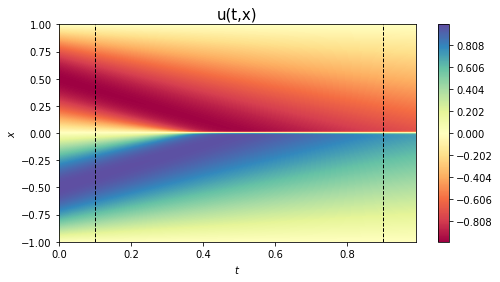

In [18]:
X, T = np.meshgrid(x_data, t_data)
plot_grid(u_data, t_data, X, T, 'u(t,x)', idx_t0, idx_t1)

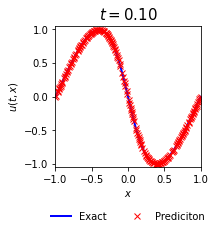

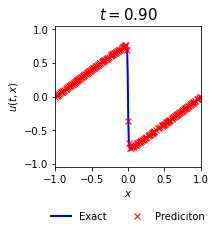

In [19]:
plot_time_step(x_data, x_0.cpu().detach().numpy(), t_data, u_data, u0_pred, idx_t0, x_data.min(), x_data.max(), u_data.min()*1.05, u_data.max()*1.05)
plot_time_step(x_data, x_1.cpu().detach().numpy(), t_data, u_data, u1_pred, idx_t1, x_data.min(), x_data.max(), u_data.min()*1.05, u_data.max()*1.05)

## SOLUTION

In [20]:
print('TARGET LAMBDA 1:', 1.,'\nTARGET LAMBDA 2', '%.6f' % (0.01/np.pi))
print('\nPREDICTED LAMBDA 1:', net.lambda_1.item(), '\nPREDICTED LAMBDA 2:', net.lambda_2.item(), '=', net.lambda_2.item() * np.pi, '/ pi')

print('\nLAMBDA 1 ABSOLUTE ERROR:', np.abs((net.lambda_1.item() - 1)))
print('LAMBDA 2 ABSOLUTE ERROR:', np.abs((net.lambda_2.item() - 0.01/np.pi) ))

print('\nLAMBDA 1 RELATIVE ERROR:', np.abs((net.lambda_1.item() - 1)/1))
print('LAMBDA 2 RELATIVE ERROR:', np.abs((net.lambda_2.item() - 0.01/np.pi) /(0.01/np.pi)))

TARGET LAMBDA 1: 1.0 
TARGET LAMBDA 2 0.003183

PREDICTED LAMBDA 1: 0.998324990272522 
PREDICTED LAMBDA 2: 0.0036664134822785854 = 0.011518377660948976 / pi

LAMBDA 1 ABSOLUTE ERROR: 0.0016750097274780273
LAMBDA 2 ABSOLUTE ERROR: 0.0004833146204406783

LAMBDA 1 RELATIVE ERROR: 0.0016750097274780273
LAMBDA 2 RELATIVE ERROR: 0.1518377660948974


In [21]:
criterion = nn.MSELoss()
Error = criterion(u0_pred[:, -1].view(-1, 1).cpu(), u_0) + criterion( u1_pred[:, -1].view(-1, 1).cpu(), u_1)

print('L2 Norm Error:', Error.item())

Error_relative = Error / (torch.mean(torch.abs(u_0)) + torch.mean(torch.abs(u_1)))
print('Relative L2 Norm Error:', Error_relative.item())

L2 Norm Error: 4.2679053209780995e-06
Relative L2 Norm Error: 4.17212961323647e-06
